# Vision Transformer in TensorFlow
> Learn the building blocs of the Vision Transformer model for image classification and how to implement it in TensorFlow

- toc: false
- badges: true
- comments: true
- author: dzlab
- categories: [tensorflow, vision, classification]

The publication of the **Vision Transformer** (or simply **ViT**) architecture in [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) had a great impact on the use of a Transformer-based architecture in computer vision problems. In fact, it was the first architecture that made good results on the ImageNet because of those two factors:
- Applying Transformers in the processing of the entire image.
- Also the training method used in ViT had impact on the model performance.



## Overview

As described in the paper [arxiv.org](https://arxiv.org/abs/2010.11929) and depicted in the following diagram, ViT works as follows: 

1. Each image is split into fixed-size patches
2. Calculate a Patch Embeddings for each patch
3. Add position embeddings a class token to each of the Patch Embeddings
4. The sequence of embeddings are passed to a Transformer encoder
5. Pass the representations through a MLP Head to get final class predictions.

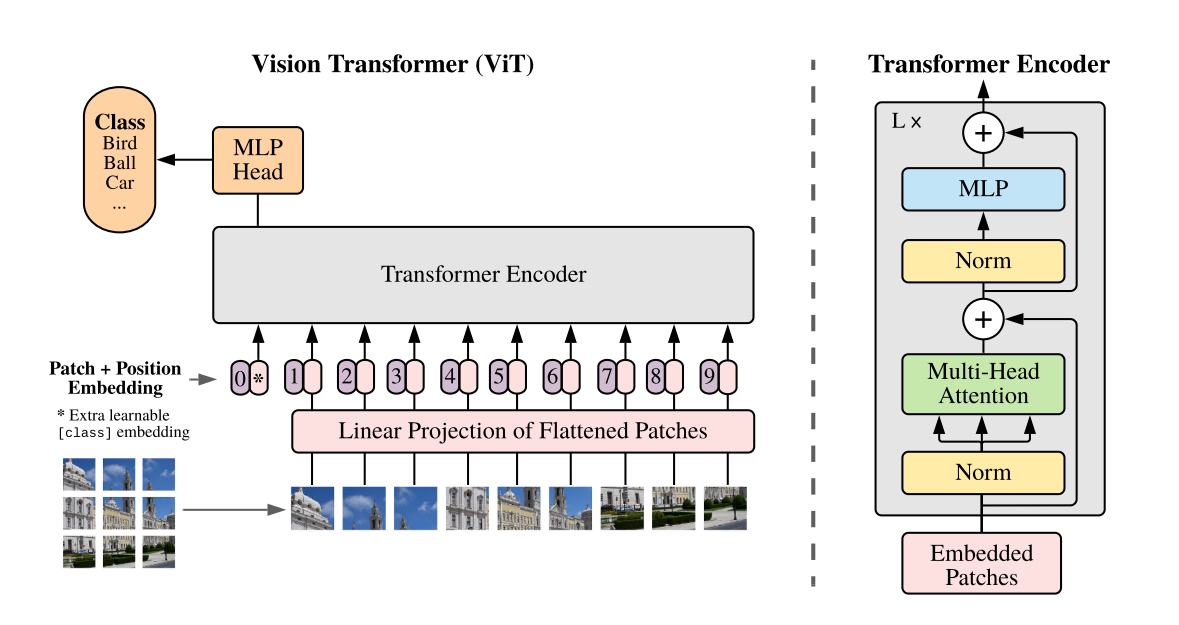

As a detailed example, when trying to classify an image (with similar size as ImageNet images: `224 x 224 x 3`, the process is as follows:


First, divide the image into patches of size `16 x 16`. This will create `14 x 14 = 196` patches. Then, we put the patches in sequence one after the other as depicted in the diagram above.

Second, pass each of those patches through a linear layer to get an embeddings vector or **Patch Embeddings** of the patch of size `1 x 768` (note that `3 x 16 x 16 = 768`). In the diagram those vectors are colored in pink.

Third, for each patch we calculate it's **Position Embeddings** (as shown in purple) then add this vector to the previous **Patch Embeddings**. We also append at the begining the embeddings of the special token `[class]`.

After this, we endup with a matrix of size `1 x 768 + 196 x 768 = 197 x 768`.

Forth, the patch embeddings are passed through **Transformer Encoder** to get the learned representations of the `[class]` token. The output will be a `1 x 768` vector.

Fifth, the representation generated by the transformer is passed to the `MLP Head` (which is simply a Linear Layer) to generate the class predictions.


## Implementation
As described in the previous section, the ViT model consits of a patch embedding, multiple Transformer blocks with self-attention layer, and a multilayer perceptron.

In the rest of this article we will go over each component of the ViT architecture and implement it in TensorFlow.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention

### Patch extraction

The first step in implementing the ViT model is the extraction of pathches from an input image as depicted in the following illustration

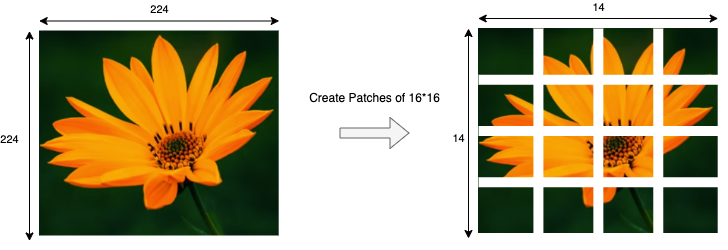

In TensorFlow, we can simply use the [tf.image.extract_patches](https://www.tensorflow.org/api_docs/python/tf/image/extract_patches) function to extract patches. We can use it inside a custom `Layer` to make it easy to use later when building the model

In [68]:
class PatchExtractor(Layer):
    def __init__(self):
        super(PatchExtractor, self).__init__()

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, 16, 16, 1],
            strides=[1, 16, 16, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [3]:
!curl -s -o flower.jpeg https://images.unsplash.com/photo-1604085572504-a392ddf0d86a?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=224&q=224 

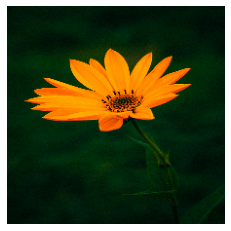

In [4]:
image = plt.imread('flower.jpeg')
image = tf.image.resize(tf.convert_to_tensor(image), size=(224, 224))
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off");

For an image of size (224, 224) we get 196 patches of 16x16

In [6]:
batch = tf.expand_dims(image, axis=0)
patches = PatchExtractor()(batch)
patches.shape

TensorShape([1, 196, 768])

We can visualize all the 196 patches

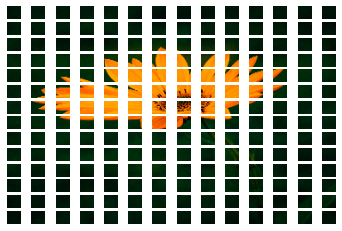

In [5]:
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (16, 16, 3))
    ax.imshow(patch_img.numpy().astype("uint8"))
    ax.axis("off")

### Patch Encoding

The Patch encoder takes as input the patches and generate their embeddings which later get passes to the Transformer. For each path, it will also create a positional embeddings vector. The following illustration describes inner working of the patch encoder.

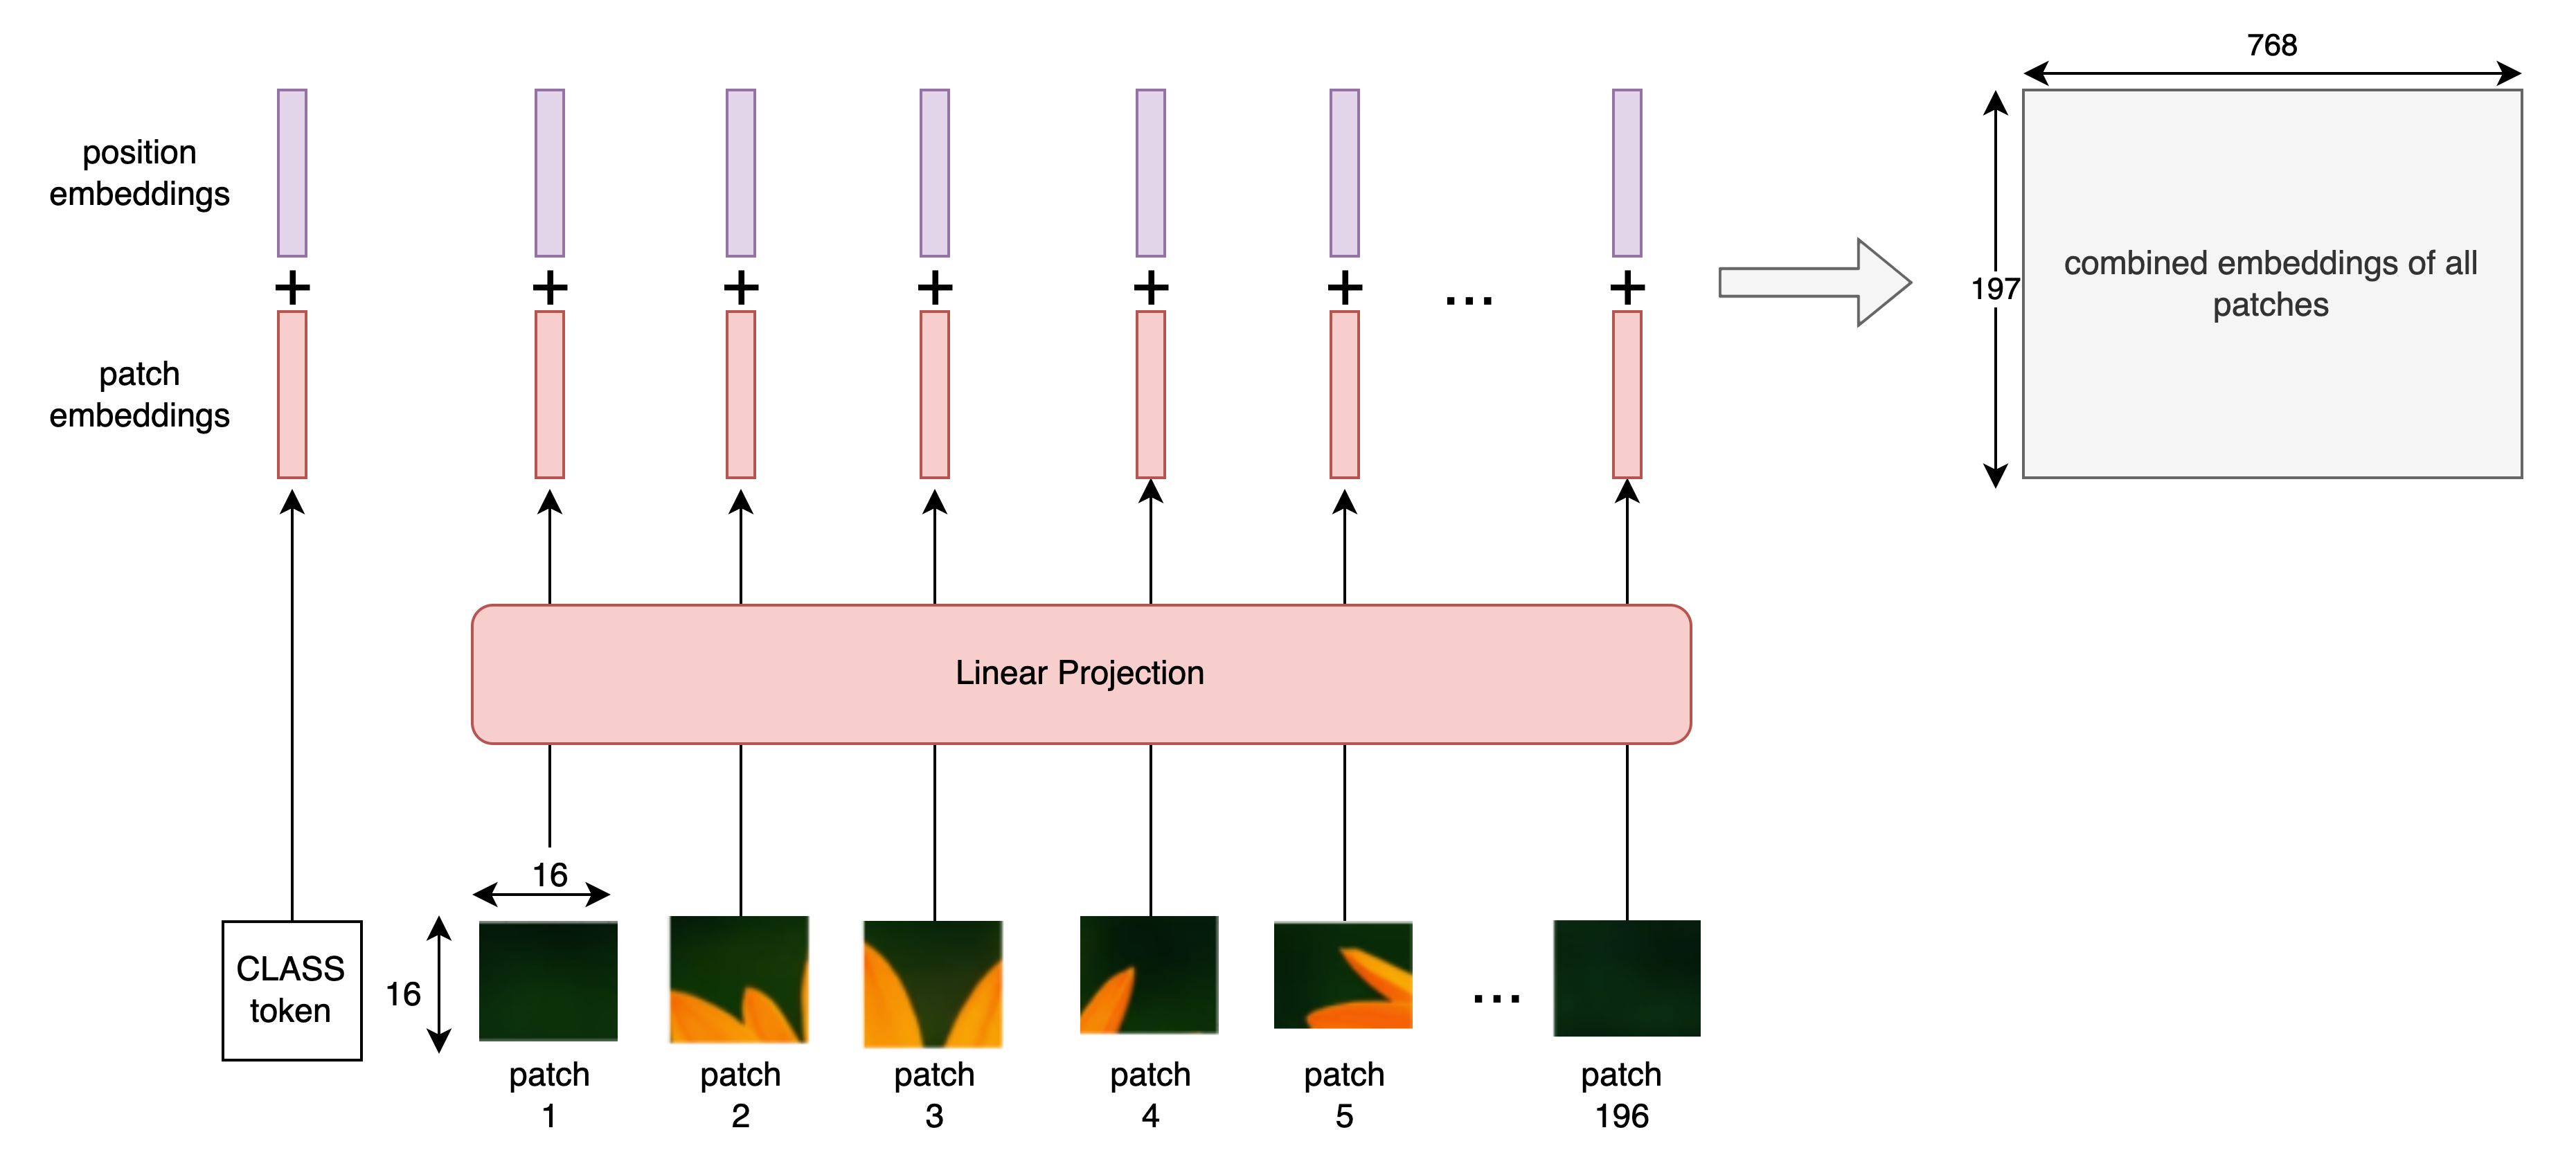

The `PatchEncoder` implementation is straightforward, we need a `Dense` layer to project a patch into a vector of size `projection_dim`, plus an `Embedding` layer to learn the positional embeddings. We also need a trainable `tf.Variable` that will learn the `[class]` token embeddings.

We use a custom layer to put all this together as follows:

In [47]:
class PatchEncoder(Layer):
    def __init__(self, num_patches=196, projection_dim=768):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches+1, output_dim=projection_dim)

    def call(self, patch):
        batch = tf.shape(patch)[0]
        # reshape the class token embedins
        class_token = tf.tile(self.class_token, multiples = [batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        patches_embed = tf.concat([patches_embed, class_token], 1)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded


We can confirm that the output of this layer is as expected `1, 197, 768`

In [48]:
embeddings = PatchEncoder()(patches)
embeddings.shape

TensorShape([1, 197, 768])

### Multilayer Perceptron

A Multilayer Perceptron (MLP) consists basically two dense layers and a `GELU` activation layer. It is used in the Transformer encoder as well as the final output layer of the ViT model. We can simply implement it as custom layer as follows:

In [54]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [56]:
mlp = MLP(768 * 2, 768)
y = mlp(tf.zeros((1, 197, 768)))
y.shape

TensorShape([1, 197, 768])

### Transformer Encoder

The transformer encoder consists of a sequence of L blocs of typical Transformer architecture. So we just need to implement the bloc once and use it multiple times

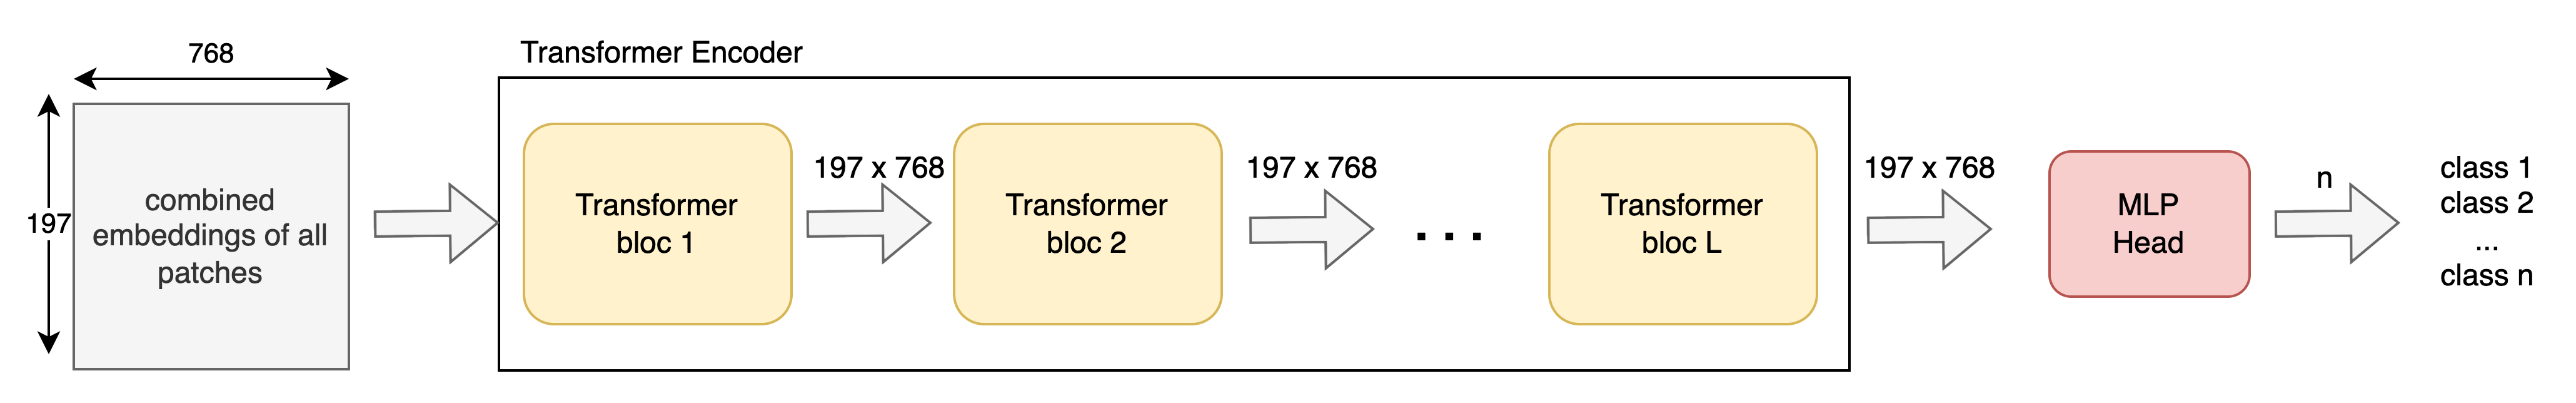

The transfomer bloc uses `LayerNormalization` and `MultiHeadAttention` layers, along with some skip connections. The following custom layer implements the Transformer bloc 

In [58]:
class Block(Layer):
    def __init__(self, projection_dim, num_heads=4, dropout_rate=0.1):
        super(Block, self).__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Layer normalization 1.
        x1 = self.norm1(x) # encoded_patches
        # Create a multi-head attention layer.
        attention_output = self.attn(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, x]) #encoded_patches
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        y = Add()([x3, x2])
        return y

In [59]:
block = Block(768)
y = block(tf.zeros((1, 197, 768)))
y.shape

TensorShape([1, 197, 768])

Now, we can simply create custom layer that implements a Transfomer using the previous `Block` layer.

In [87]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=4, num_blocks=12, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        self.norm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.5)

    def call(self, x):
        # Create a [batch_size, projection_dim] tensor.
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        y = self.dropout(x)
        return y

In [88]:
transformer = TransformerEncoder(768)
y = transformer(embeddings)
y.shape

TensorShape([1, 197, 768])

## Putting it together

After defining all the major components of the ViT architecture, we can put them together to build the model. This is fairly straightforward now as we just need to plug a patch extract to an encoder to a transformer to a multilayer perceptron as depicted in the following diagram

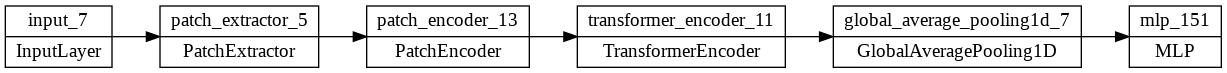

In [92]:
def create_VisionTransformer(num_classes, num_patches=196, projection_dim=768, input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = MLP(projection_dim, num_classes, 0.5)(representation)
    # Create model
    model = Model(inputs=inputs, outputs=logits)
    return model

In [93]:
model = create_VisionTransformer(2)

In [94]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 patch_extractor_5 (PatchExt  (None, None, 768)        0         
 ractor)                                                         
                                                                 
 patch_encoder_13 (PatchEnco  (None, 197, 768)         742656    
 der)                                                            
                                                                 
 transformer_encoder_11 (Tra  (None, 197, 768)         141743616 
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_7   (None, 768)              0         
 (GlobalAveragePooling1D)                                  

## That's all folks

I hope you enjoyed this article, feel free to leave a comment or reach out on twitter [@bachiirc](https://twitter.com/bachiirc)